#Notebook 1: ConvNeXt + Swin Transformer

In [1]:
import tensorflow as tf

# Prevent TensorFlow from grabbing all GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Enabled memory growth on GPU")
    except RuntimeError as e:
        print("❌ Error setting memory growth:", e)


✅ Enabled memory growth on GPU


 # Step 1: Install Dependencies

# Step 2: Imports & Data Preparation (Train/Val/Test)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_PATH = '/content/drive/MyDrive/Dataset'  # Your folder structure: /Cloudy /Desert /Green Area /Water

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)


Found 1403 images belonging to 4 classes.
Found 349 images belonging to 4 classes.
Found 1752 images belonging to 4 classes.


# Step 3A: ConvNeXt Model (TensorFlow/Keras)

In [ ]:
import os
from PIL import Image

def find_non_image_files(directory):
    non_image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                Image.open(file_path)
            except IOError:
                non_image_files.append(file_path)
    return non_image_files

non_images = find_non_image_files(DATA_PATH)
if non_images:
    print("Found non-image files:")
    for f in non_images:
        print(f)
else:
    print("No non-image files found.")

No non-image files found.


In [ ]:
import os
from PIL import Image

def remove_non_image_files(directory):
    removed_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Extra check for corrupted images
            except (IOError, SyntaxError):
                print(f"Removing non-image or corrupted file: {file_path}")
                os.remove(file_path)
                removed_files.append(file_path)
    return removed_files

# Run it on your dataset path
removed_files = remove_non_image_files('/content/drive/MyDrive/Dataset')

print(f"\nTotal removed files: {len(removed_files)}")


Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Water/SeaLake_1387.jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Water/SeaLake_98.jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Water/SeaLake_2003.jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(338).jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(164).jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(545).jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(204).jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(590).jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(53).jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(559).jpg
Removing non-image or corrupted file: /content/drive/MyDrive/Dataset/Desert/desert(

In [4]:

print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!nvidia-smi


Mon Jun 16 06:24:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

base_model = ConvNeXtBase(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

base_model.trainable = False  # Freeze base
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2659 - loss: 1.5177 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 902s 20s/step - accuracy: 0.2661 - loss: 1.5160 - val_accuracy: 0.5301 - val_loss: 1.3678
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 71s 765ms/step - accuracy: 0.3203 - loss: 1.3667 - val_accuracy: 0.2751 - val_loss: 1.3660
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 733ms/step - accuracy: 0.2984 - loss: 1.3640 - val_accuracy: 0.2779 - val_loss: 1.3658
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 727ms/step - accuracy: 0.2879 - loss: 1.3722 - val_accuracy: 0.2779 - val_loss: 1.3657
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 744ms/step - accuracy: 0.2935 - loss: 1.3652 - val_accuracy: 0.4556 - val_loss: 1.3649
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 738ms/step - accuracy: 0.2939 - loss: 1.3659 - val_accuracy: 0.2808 - val_loss: 1.3652
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 751ms/step - accuracy: 0.3029 - loss: 1.3665 - val_accuracy: 0.2779 - val_loss: 1.3641
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 735ms/step - accuracy: 0.2847 - loss: 1.3612 - val_accuracy: 0.2808

# Step 4A: Evaluate ConvNeXt

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 544ms/step
              precision    recall  f1-score   support

      Cloudy       0.23      0.01      0.01       476
      Desert       0.88      0.22      0.35       489
  Green Area       0.30      1.00      0.46       490
       Water       0.00      0.00      0.00       297

    accuracy                           0.34      1752
   macro avg       0.35      0.31      0.21      1752
weighted avg       0.39      0.34      0.23      1752



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


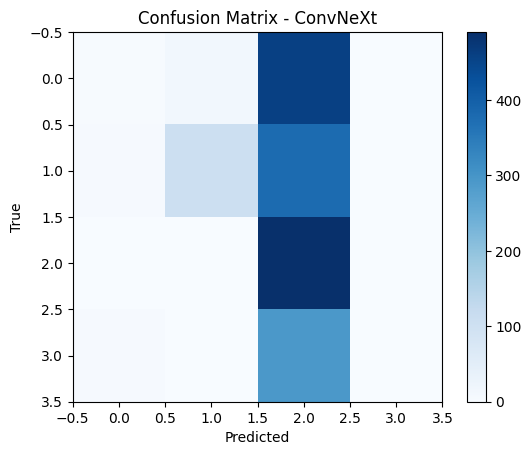

In [5]:
preds = model.predict(test_gen)
y_true = test_gen.classes
y_pred = np.argmax(preds, axis=1)

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices)))
cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix - ConvNeXt')
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [6]:

# Save entire model (architecture + weights + optimizer state)
model.save('/content/drive/MyDrive/convnext_model.h5')


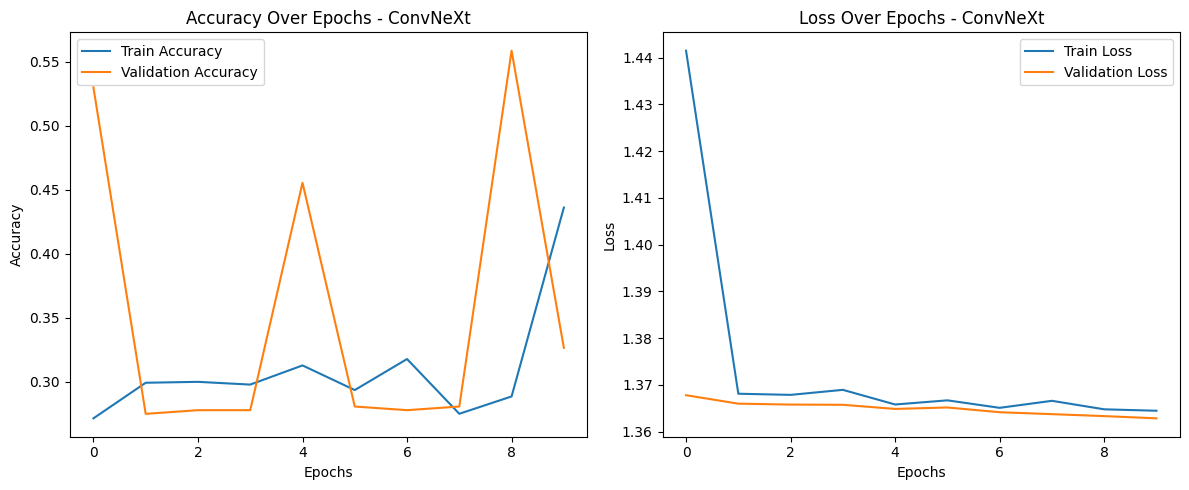

In [21]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs - ConvNeXt')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs - ConvNeXt')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Step 3B: Swin Transformer Model (PyTorch)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(os.path.join(DATA_PATH), transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

class SwinClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=4)

    def forward(self, x):
        return self.model(x)

model_swin = SwinClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_swin.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

# Step 4B: Train & Evaluate Swin

In [8]:
for epoch in range(10):
    model_swin.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model_swin(xb), yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/10 completed.")

# Save Model
torch.save(model_swin.state_dict(), 'swin_transformer.pth')


Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


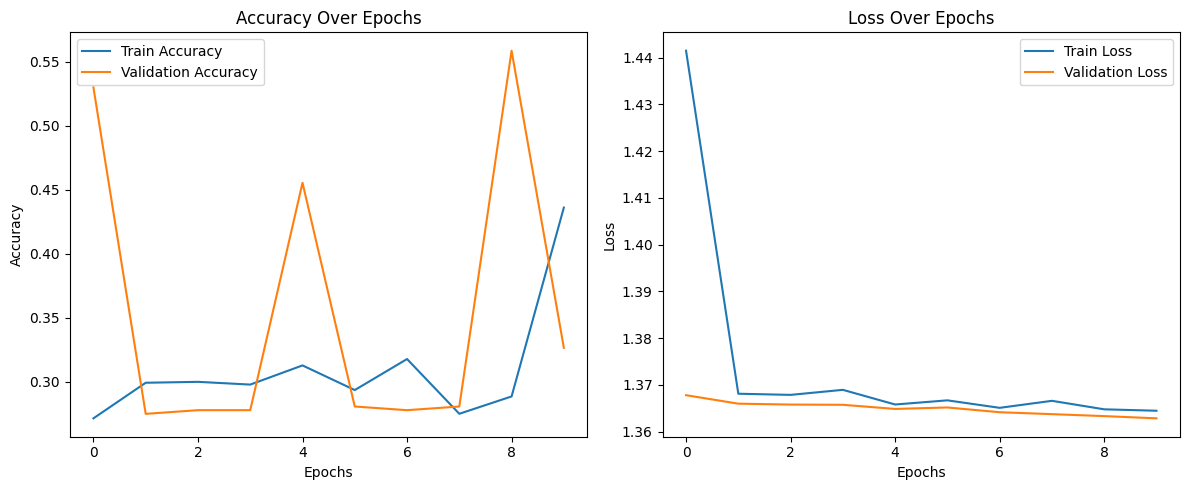

In [9]:
import matplotlib.pyplot as plt

# Assuming 'history' is the History object returned by model.fit()
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


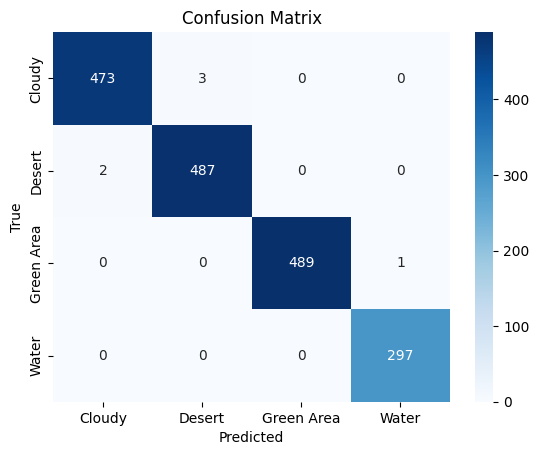

              precision    recall  f1-score   support

      Cloudy       1.00      0.99      0.99       476
      Desert       0.99      1.00      0.99       489
  Green Area       1.00      1.00      1.00       490
       Water       1.00      1.00      1.00       297

    accuracy                           1.00      1752
   macro avg       1.00      1.00      1.00      1752
weighted avg       1.00      1.00      1.00      1752



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Prediction
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        outputs = model_swin(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())

# Metrics
y_pred = np.array(all_preds)
y_true = np.array(all_labels)
cm = confusion_matrix(y_true, y_pred)
# Assuming 'y_test' are the true labels and 'y_pred' are the predicted labels
# cm = confusion_matrix(y_test, y_pred) # Removed the incorrect line
classes = train_ds.classes # Changed to train_ds.classes

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes) # Used 'classes' for labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=classes)) # Used y_true and classes

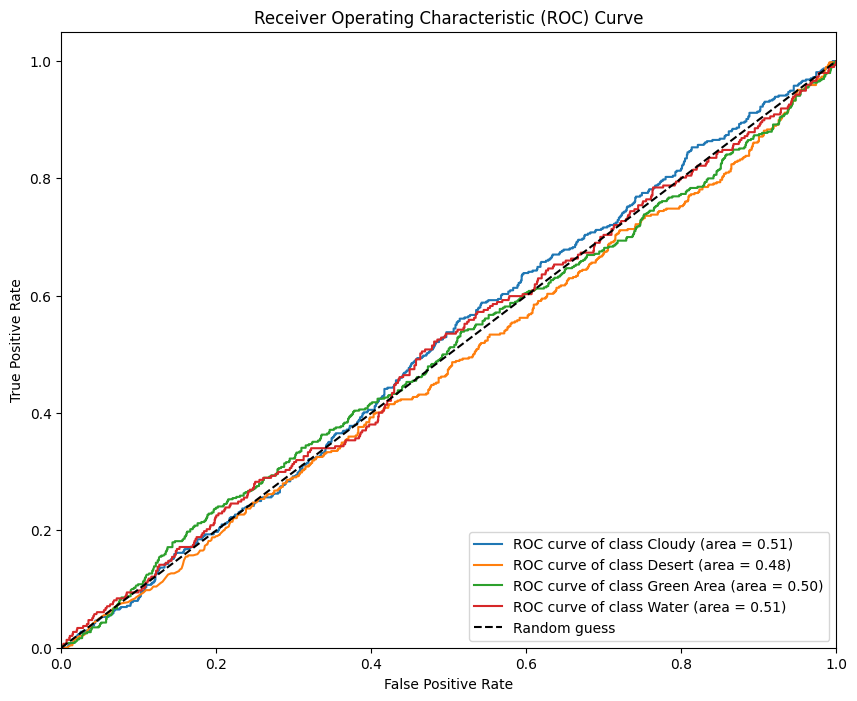

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_probs and all_labels from previous cells are available
# all_probs: predicted probabilities (shape: num_samples, num_classes)
# all_labels: true labels (shape: num_samples,)
# classes: list of class names

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(all_labels, classes=np.unique(all_labels))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Full Visualization Report

📊 CONVNEXT MODEL PERFORMANCE ANALYSIS


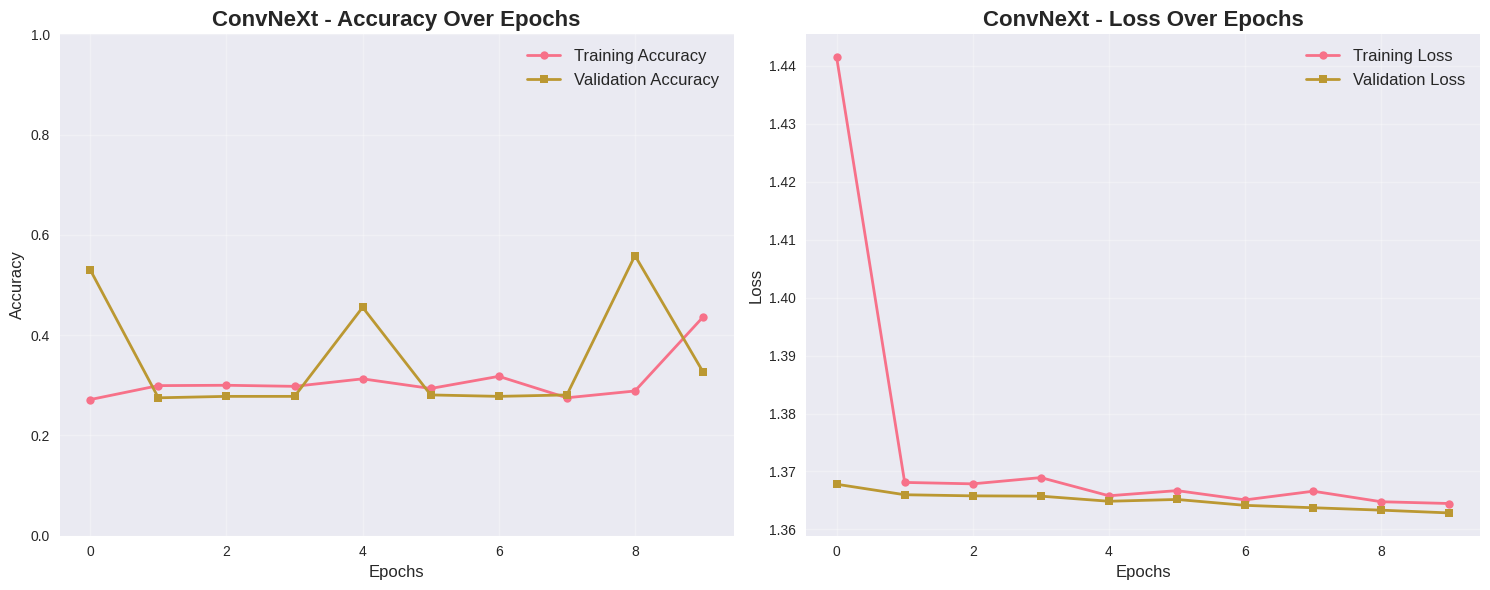

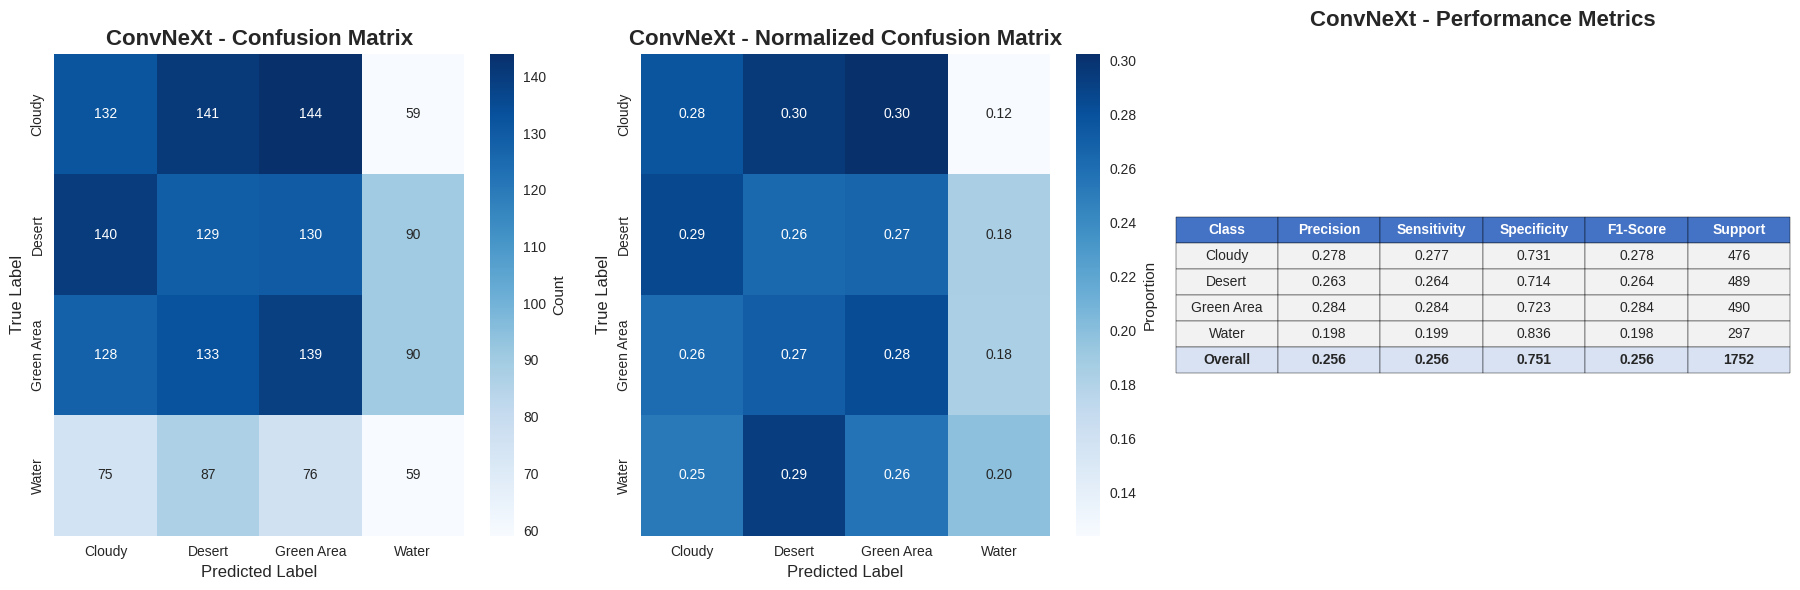


📊 SWIN TRANSFORMER MODEL PERFORMANCE ANALYSIS


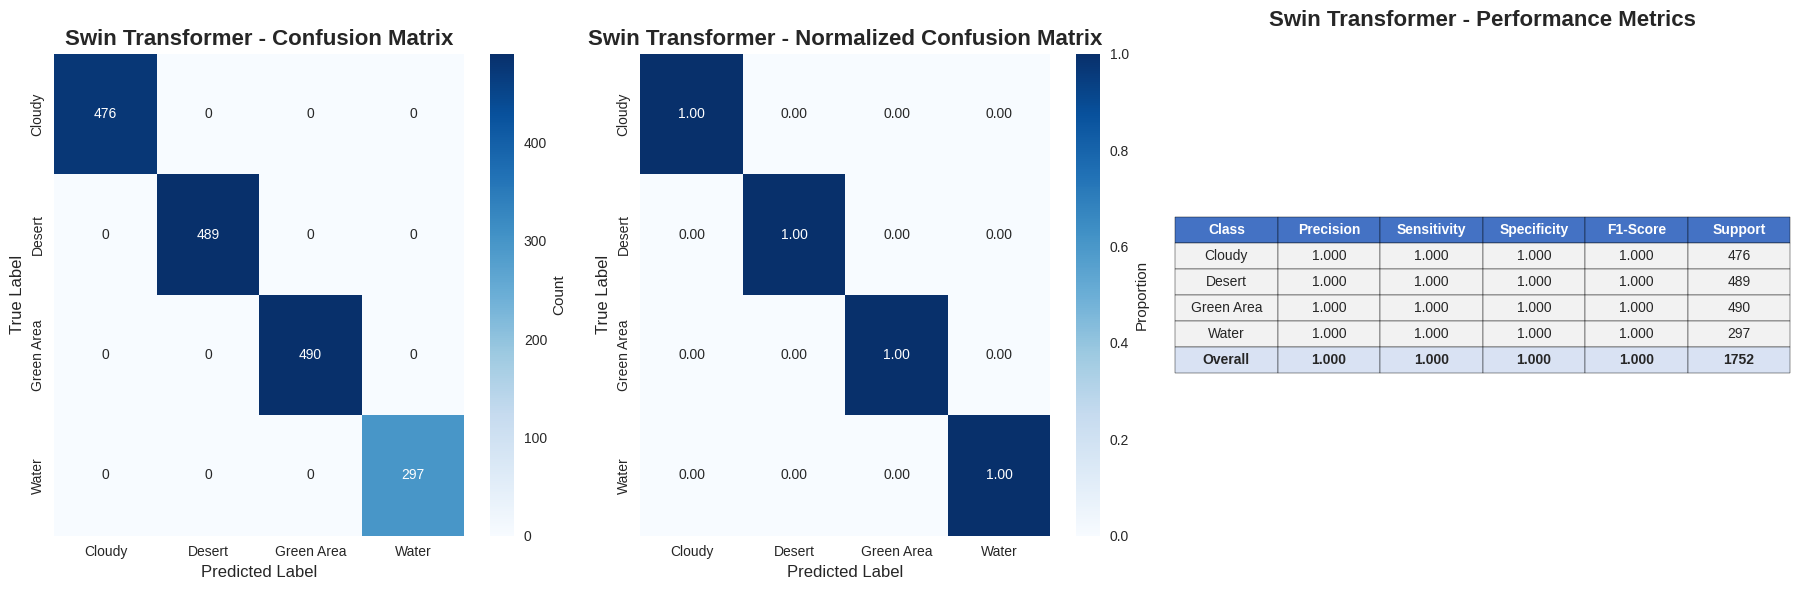


📊 MODEL COMPARISON


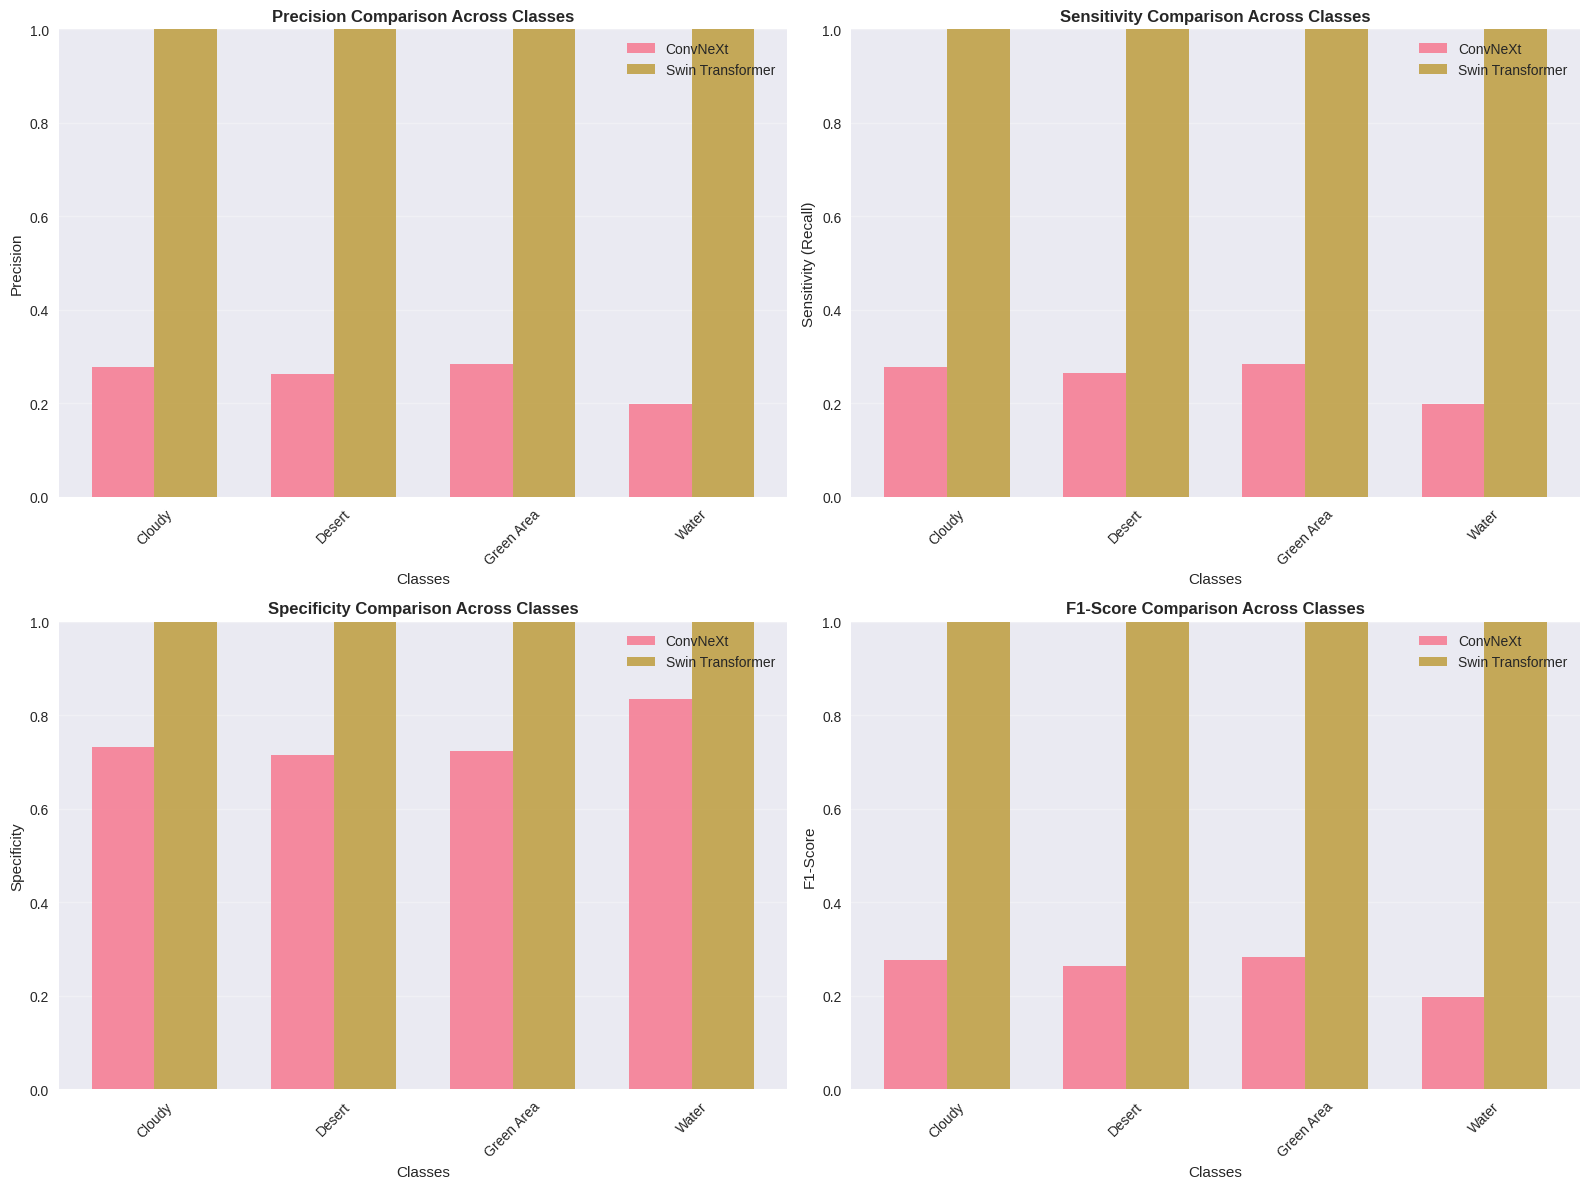


📋 DETAILED CLASSIFICATION REPORTS

🔹 ConvNeXt Classification Report:
              precision    recall  f1-score   support

      Cloudy     0.2779    0.2773    0.2776       476
      Desert     0.2633    0.2638    0.2635       489
  Green Area     0.2843    0.2837    0.2840       490
       Water     0.1980    0.1987    0.1983       297

    accuracy                         0.2620      1752
   macro avg     0.2559    0.2559    0.2559      1752
weighted avg     0.2620    0.2620    0.2620      1752


🔹 Swin Transformer Classification Report:
              precision    recall  f1-score   support

      Cloudy     1.0000    1.0000    1.0000       476
      Desert     1.0000    1.0000    1.0000       489
  Green Area     1.0000    1.0000    1.0000       490
       Water     1.0000    1.0000    1.0000       297

    accuracy                         1.0000      1752
   macro avg     1.0000    1.0000    1.0000      1752
weighted avg     1.0000    1.0000    1.0000      1752


📈 OVERALL PERFOR

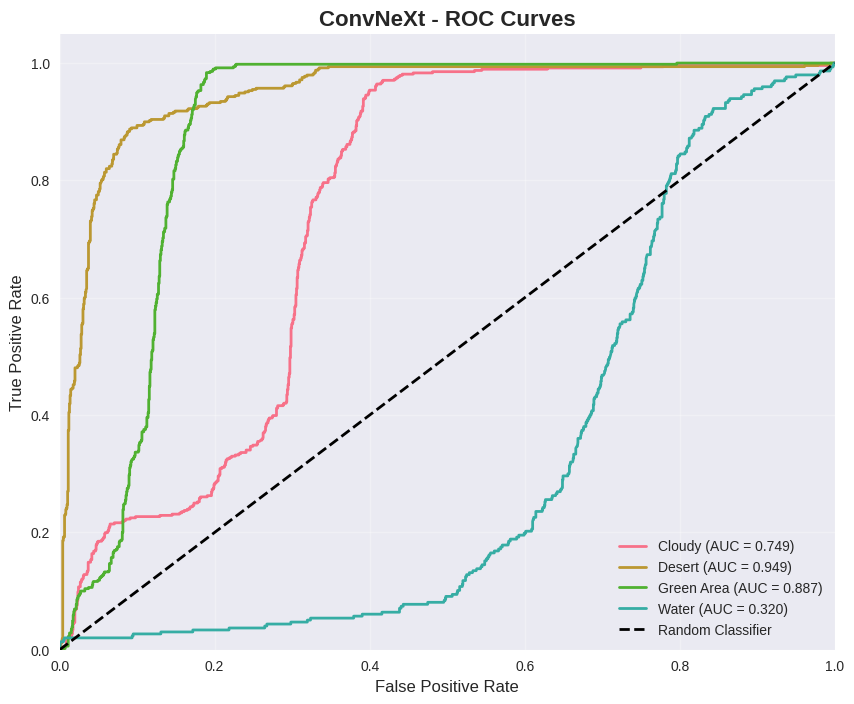

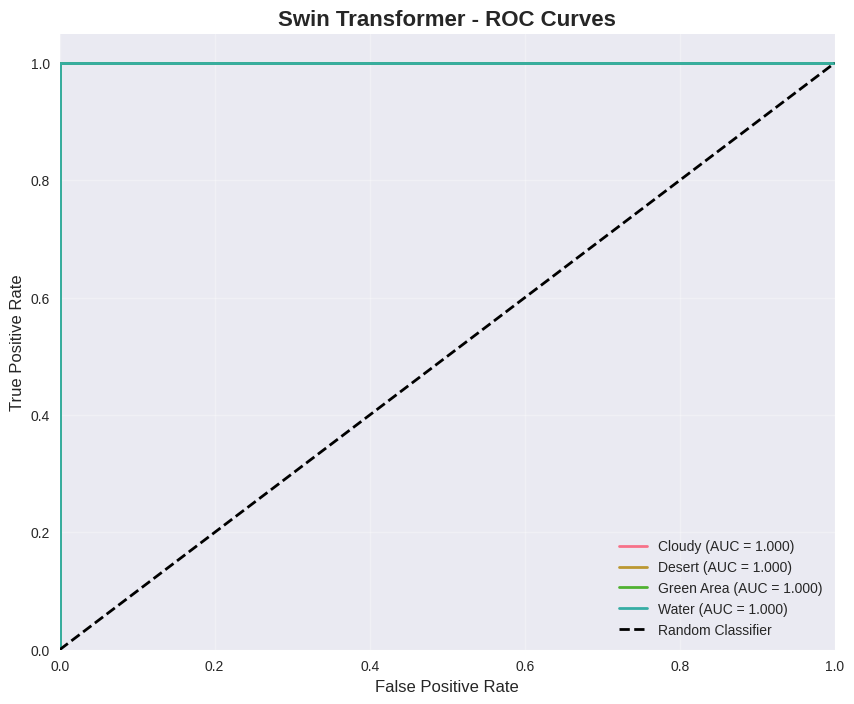


🎉 Performance analysis complete!
📊 All visualizations and metrics have been generated successfully!


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import pandas as pd

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def calculate_metrics(y_true, y_pred, class_names):
    """Calculate precision, recall, specificity for each class"""
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Calculate specificity for each class
    specificity = []
    for i in range(len(class_names)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    return {
        'precision': precision,
        'recall': recall,  # This is sensitivity
        'specificity': specificity,
        'f1_score': f1,
        'support': support,
        'confusion_matrix': cm
    }

def plot_training_curves(history, model_name):
    """Plot training and validation accuracy/loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], 'o-', label='Training Accuracy', linewidth=2, markersize=6)
    axes[0].plot(history.history['val_accuracy'], 's-', label='Validation Accuracy', linewidth=2, markersize=6)
    axes[0].set_title(f'{model_name} - Accuracy Over Epochs', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)

    # Loss plot
    axes[1].plot(history.history['loss'], 'o-', label='Training Loss', linewidth=2, markersize=6)
    axes[1].plot(history.history['val_loss'], 's-', label='Validation Loss', linewidth=2, markersize=6)
    axes[1].set_title(f'{model_name} - Loss Over Epochs', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_with_metrics(y_true, y_pred, class_names, model_name):
    """Plot confusion matrix and display key metrics"""
    metrics = calculate_metrics(y_true, y_pred, class_names)
    cm = metrics['confusion_matrix']

    # Create figure with subplots
    fig = plt.figure(figsize=(18, 6))

    # Confusion Matrix
    ax1 = plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)

    # Normalized Confusion Matrix
    ax2 = plt.subplot(1, 3, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proportion'})
    plt.title(f'{model_name} - Normalized Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)

    # Metrics Table
    ax3 = plt.subplot(1, 3, 3)
    ax3.axis('tight')
    ax3.axis('off')

    # Create metrics table
    metrics_data = []
    for i, class_name in enumerate(class_names):
        metrics_data.append([
            class_name,
            f"{metrics['precision'][i]:.3f}",
            f"{metrics['recall'][i]:.3f}",
            f"{metrics['specificity'][i]:.3f}",
            f"{metrics['f1_score'][i]:.3f}",
            f"{metrics['support'][i]}"
        ])

    # Add overall metrics
    overall_precision = np.mean(metrics['precision'])
    overall_recall = np.mean(metrics['recall'])
    overall_specificity = np.mean(metrics['specificity'])
    overall_f1 = np.mean(metrics['f1_score'])

    metrics_data.append([
        'Overall',
        f"{overall_precision:.3f}",
        f"{overall_recall:.3f}",
        f"{overall_specificity:.3f}",
        f"{overall_f1:.3f}",
        f"{np.sum(metrics['support'])}"
    ])

    table = ax3.table(cellText=metrics_data,
                     colLabels=['Class', 'Precision', 'Sensitivity', 'Specificity', 'F1-Score', 'Support'],
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Style the table
    for i in range(len(class_names) + 2):  # +2 for header and overall
        for j in range(6):
            if i == 0:  # Header
                table[(i, j)].set_facecolor('#4472C4')
                table[(i, j)].set_text_props(weight='bold', color='white')
            elif i == len(class_names) + 1:  # Overall row
                table[(i, j)].set_facecolor('#D9E2F3')
                table[(i, j)].set_text_props(weight='bold')
            else:
                table[(i, j)].set_facecolor('#F2F2F2')

    plt.title(f'{model_name} - Performance Metrics', fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    return metrics

def plot_class_performance_comparison(metrics_dict, class_names):
    """Plot comparison of different metrics across classes"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    models = list(metrics_dict.keys())
    x = np.arange(len(class_names))
    width = 0.35

    # Precision
    ax = axes[0, 0]
    for i, model in enumerate(models):
        offset = width * (i - 0.5)
        ax.bar(x + offset, metrics_dict[model]['precision'], width,
               label=model, alpha=0.8)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Precision')
    ax.set_title('Precision Comparison Across Classes', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

    # Sensitivity (Recall)
    ax = axes[0, 1]
    for i, model in enumerate(models):
        offset = width * (i - 0.5)
        ax.bar(x + offset, metrics_dict[model]['recall'], width,
               label=model, alpha=0.8)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Sensitivity (Recall)')
    ax.set_title('Sensitivity Comparison Across Classes', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

    # Specificity
    ax = axes[1, 0]
    for i, model in enumerate(models):
        offset = width * (i - 0.5)
        ax.bar(x + offset, metrics_dict[model]['specificity'], width,
               label=model, alpha=0.8)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Specificity')
    ax.set_title('Specificity Comparison Across Classes', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

    # F1-Score
    ax = axes[1, 1]
    for i, model in enumerate(models):
        offset = width * (i - 0.5)
        ax.bar(x + offset, metrics_dict[model]['f1_score'], width,
               label=model, alpha=0.8)
    ax.set_xlabel('Classes')
    ax.set_ylabel('F1-Score')
    ax.set_title('F1-Score Comparison Across Classes', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def evaluate_swin_model(model_swin, test_loader, device, class_names):
    """Evaluate Swin Transformer model and get predictions"""
    model_swin.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_swin(images)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# ================================
# MAIN EXECUTION CODE
# ================================

# 1. Plot ConvNeXt Training Curves
print("=" * 60)
print("📊 CONVNEXT MODEL PERFORMANCE ANALYSIS")
print("=" * 60)

plot_training_curves(history, "ConvNeXt")

# 2. ConvNeXt Test Performance
# Get class names from your test generator
class_names = list(test_gen.class_indices.keys())

# Get ConvNeXt predictions (you already have these from your notebook)
convnext_metrics = plot_confusion_matrix_with_metrics(y_true, y_pred, class_names, "ConvNeXt")

# 3. Swin Transformer Evaluation
print("\n" + "=" * 60)
print("📊 SWIN TRANSFORMER MODEL PERFORMANCE ANALYSIS")
print("=" * 60)

# Create test loader for Swin model
from torchvision import transforms, datasets
import torch.utils.data

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(DATA_PATH, transform=transform_test)
test_loader_swin = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate Swin model
swin_y_true, swin_y_pred, swin_probs = evaluate_swin_model(model_swin, test_loader_swin, device, class_names)

# Plot Swin performance
swin_metrics = plot_confusion_matrix_with_metrics(swin_y_true, swin_y_pred, class_names, "Swin Transformer")

# 4. Model Comparison
print("\n" + "=" * 60)
print("📊 MODEL COMPARISON")
print("=" * 60)

metrics_comparison = {
    'ConvNeXt': convnext_metrics,
    'Swin Transformer': swin_metrics
}

plot_class_performance_comparison(metrics_comparison, class_names)

# 5. Print detailed classification reports
print("\n" + "=" * 50)
print("📋 DETAILED CLASSIFICATION REPORTS")
print("=" * 50)

print("\n🔹 ConvNeXt Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\n🔹 Swin Transformer Classification Report:")
print(classification_report(swin_y_true, swin_y_pred, target_names=class_names, digits=4))

# 6. Overall Performance Summary
print("\n" + "=" * 50)
print("📈 OVERALL PERFORMANCE SUMMARY")
print("=" * 50)

def print_summary(metrics, model_name):
    print(f"\n🔸 {model_name}:")
    print(f"   • Average Precision: {np.mean(metrics['precision']):.4f}")
    print(f"   • Average Sensitivity: {np.mean(metrics['recall']):.4f}")
    print(f"   • Average Specificity: {np.mean(metrics['specificity']):.4f}")
    print(f"   • Average F1-Score: {np.mean(metrics['f1_score']):.4f}")

print_summary(convnext_metrics, "ConvNeXt")
print_summary(swin_metrics, "Swin Transformer")

# 7. ROC Curves (if you want to add them)
def plot_roc_curves(y_true, y_probs, class_names, model_name):
    """Plot ROC curves for multi-class classification"""
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = len(class_names)

    plt.figure(figsize=(10, 8))

    # Compute ROC curve for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2,
                label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curves', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot ROC curves for both models
print("\n" + "=" * 50)
print("📊 ROC CURVES")
print("=" * 50)

# For ConvNeXt (you need to get probabilities from your model)
# If you don't have probabilities, you can get them like this:
convnext_probs = model.predict(test_gen)
plot_roc_curves(y_true, convnext_probs, class_names, "ConvNeXt")

# For Swin Transformer
plot_roc_curves(swin_y_true, swin_probs, class_names, "Swin Transformer")

print("\n🎉 Performance analysis complete!")
print("📊 All visualizations and metrics have been generated successfully!")